In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import pickle
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [2]:
# Set plot style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

In [3]:
import joblib


src = r"E:\1_RecSys\Recommender\data\collaborative\v2\2_user_item_matrix.pkl"
user_item_matrix = joblib.load(src)

Matrix shape: (610, 2269)
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>
Matrix non-zeros: 64661
Matrix sparsity: 0.046717
Found 0 empty items at indices: []
Found 0 empty users at indices: []

--- Item Matrix Analysis ---
Item Matrix 70% variance explained by 104 components
Item Matrix 80% variance explained by 156 components
Item Matrix 90% variance explained by 246 components
Item Matrix 95% variance explained by 330 components
Item Matrix 99% variance explained by 477 components


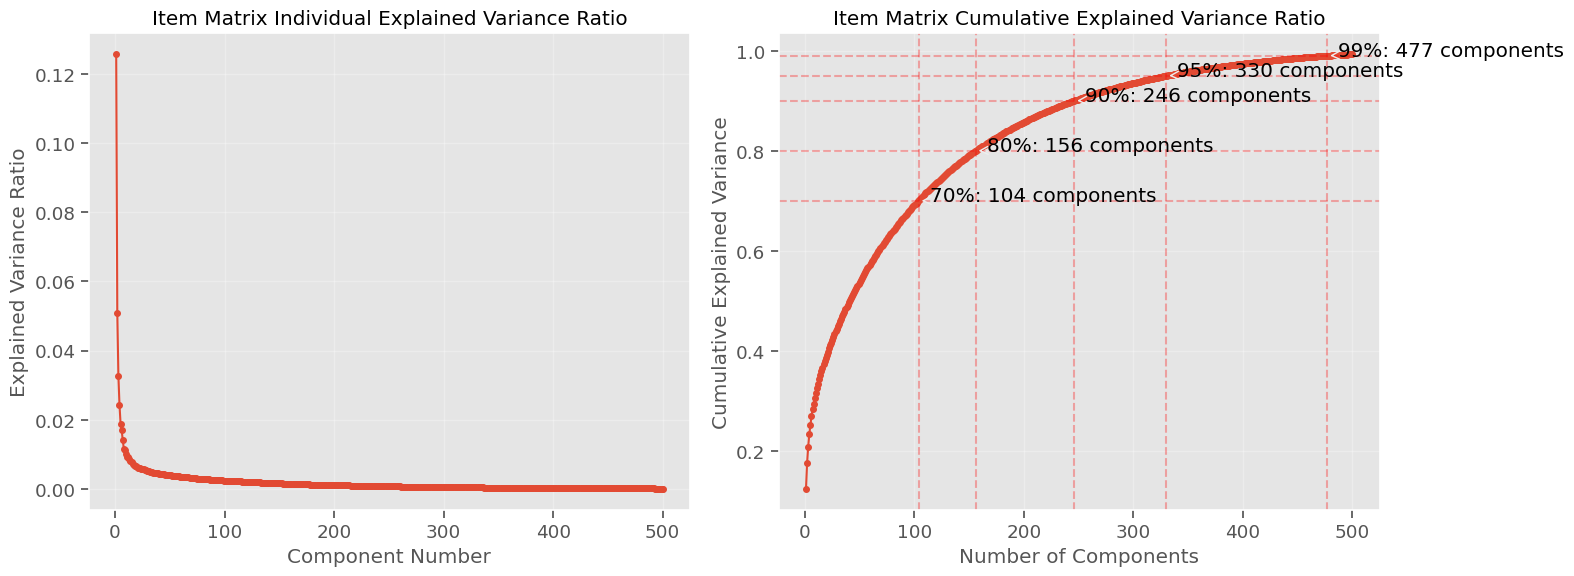


--- User Matrix Analysis ---
User Matrix 70% variance explained by 103 components
User Matrix 80% variance explained by 155 components
User Matrix 90% variance explained by 245 components
User Matrix 95% variance explained by 329 components
User Matrix 99% variance explained by 477 components


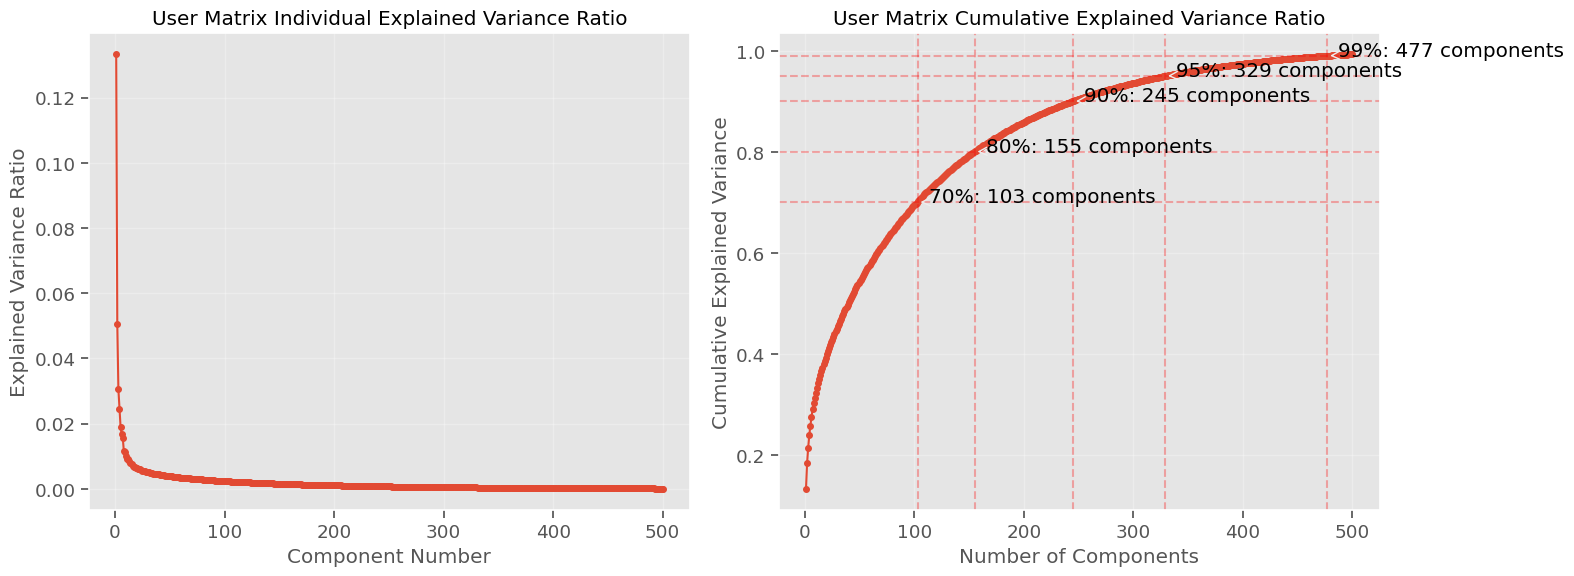


--- Optimal Number of Components ---
Item Matrix Optimal Components:
  elbow: 488
  70%_variance: 104
  80%_variance: 156
  90%_variance: 246
  95%_variance: 330
  99%_variance: 477
  min_1pct_contrib: 10

User Matrix Optimal Components:
  elbow: 191
  70%_variance: 103
  80%_variance: 155
  90%_variance: 245
  95%_variance: 329
  99%_variance: 477
  min_1pct_contrib: 9


In [4]:

# Print basic information
print(f"Matrix shape: {user_item_matrix.shape}")
print(f"Matrix type: {type(user_item_matrix)}")
print(f"Matrix non-zeros: {user_item_matrix.nnz}")
print(f"Matrix sparsity: {user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.6f}")

# Find empty columns
matrix_csc = user_item_matrix.tocsc()
item_interaction_counts = np.diff(matrix_csc.indptr)
empty_item_indices = np.where(item_interaction_counts == 0)[0]
print(f"Found {len(empty_item_indices)} empty items at indices: {empty_item_indices}")

# Find empty rows
user_interaction_counts = np.diff(user_item_matrix.indptr)
empty_user_indices = np.where(user_interaction_counts == 0)[0]
print(f"Found {len(empty_user_indices)} empty users at indices: {empty_user_indices}")

# Item-Item Matrix Analysis
# Transpose to get item-user matrix
item_user_matrix = user_item_matrix.T.tocsr()

# Function to analyze SVD components and explained variance
def analyze_svd_components(matrix, max_components=None, title_prefix=""):
    """Analyze SVD components and their explained variance ratio"""
    n_rows, n_cols = matrix.shape
    
    if max_components is None:
        max_components = min(n_rows, n_cols) - 1
    
    # Cap max_components to avoid memory issues (adjust as needed)
    max_components = min(max_components, 500)
    
    # Run SVD
    svd = TruncatedSVD(n_components=max_components, random_state=42)
    transformed = svd.fit_transform(matrix)
    
    # Get explained variance ratio
    explained_variance_ratio = svd.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Plot explained variance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot individual explained variance
    ax1.plot(range(1, max_components + 1), explained_variance_ratio, 'o-', markersize=4)
    ax1.set_title(f'{title_prefix} Individual Explained Variance Ratio')
    ax1.set_xlabel('Component Number')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.grid(True, alpha=0.3)
    
    # Plot cumulative explained variance
    ax2.plot(range(1, max_components + 1), cumulative_variance_ratio, 'o-', markersize=4)
    ax2.set_title(f'{title_prefix} Cumulative Explained Variance Ratio')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.grid(True, alpha=0.3)
    
    # Add threshold lines
    for threshold in [0.7, 0.8, 0.9, 0.95, 0.99]:
        try:
            n_components = np.where(cumulative_variance_ratio >= threshold)[0][0] + 1
            ax2.axhline(y=threshold, color='r', linestyle='--', alpha=0.3)
            ax2.axvline(x=n_components, color='r', linestyle='--', alpha=0.3)
            ax2.annotate(f'{threshold:.0%}: {n_components} components', 
                         xy=(n_components, threshold),
                         xytext=(n_components+10, threshold),
                         arrowprops=dict(arrowstyle='->'))
            print(f"{title_prefix} {threshold:.0%} variance explained by {n_components} components")
        except IndexError:
            print(f"{title_prefix} {threshold:.0%} variance threshold not reached with {max_components} components")
    
    plt.tight_layout()
    plt.show()
    
    # Check for zero vectors in transformed matrix
    zero_vector_mask = np.all(transformed == 0, axis=1)
    zero_vector_indices = np.where(zero_vector_mask)[0]
    if len(zero_vector_indices) > 0:
        print(f"Warning: Found {len(zero_vector_indices)} zero vectors in the transformed matrix")
        print(f"Zero vector indices: {zero_vector_indices}")
        
        # For each zero vector, check original interactions
        for idx in zero_vector_indices:
            original_interactions = matrix[idx].nnz
            print(f"  Row {idx} has {original_interactions} interactions in original data")
    
    return explained_variance_ratio, cumulative_variance_ratio, transformed

# Analyze item matrix SVD components
print("\n--- Item Matrix Analysis ---")
item_variance_ratio, item_cumulative_ratio, item_transformed = analyze_svd_components(
    item_user_matrix, 
    title_prefix="Item Matrix"
)

# Analyze user matrix SVD components
print("\n--- User Matrix Analysis ---")
user_variance_ratio, user_cumulative_ratio, user_transformed = analyze_svd_components(
    user_item_matrix, 
    title_prefix="User Matrix"
)

# Find optimal number of components based on different criteria
def find_optimal_components(variance_ratio, cumulative_ratio):
    results = {}
    
    # 1. Elbow method (find point of maximum curvature)
    # Approximate by finding where second derivative is maximum
    second_derivative = np.diff(np.diff(cumulative_ratio))
    elbow_idx = np.argmax(second_derivative) + 2  # +2 because of two diff operations
    results['elbow'] = elbow_idx
    
    # 2. Various variance thresholds
    for threshold in [0.7, 0.8, 0.9, 0.95, 0.99]:
        try:
            idx = np.where(cumulative_ratio >= threshold)[0][0] + 1
            results[f'{int(threshold*100)}%_variance'] = idx
        except IndexError:
            results[f'{int(threshold*100)}%_variance'] = "Not reached"
    
    # 3. Minimum components that explain at least 1% individually
    min_contrib = 0.01  # 1%
    min_contrib_count = np.sum(variance_ratio >= min_contrib)
    results['min_1pct_contrib'] = min_contrib_count
    
    return results

# Find optimal components
print("\n--- Optimal Number of Components ---")
item_optimal = find_optimal_components(item_variance_ratio, item_cumulative_ratio)
user_optimal = find_optimal_components(user_variance_ratio, user_cumulative_ratio)

print("Item Matrix Optimal Components:")
for criterion, value in item_optimal.items():
    print(f"  {criterion}: {value}")

print("\nUser Matrix Optimal Components:")
for criterion, value in user_optimal.items():
    print(f"  {criterion}: {value}")

# Plot zero vectors (if any) in original space
if len(empty_item_indices) > 0:
    plt.figure(figsize=(10, 6))
    plt.spy(item_user_matrix[empty_item_indices, :], marker='.', markersize=2)
    plt.title('Visualization of Empty Item Rows')
    plt.xlabel('User Index')
    plt.ylabel('Item Index (empty items only)')
    plt.show()